<a href="https://colab.research.google.com/github/waigani64/Chemical-Modeling/blob/main/Water_Radiolysis_Grok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

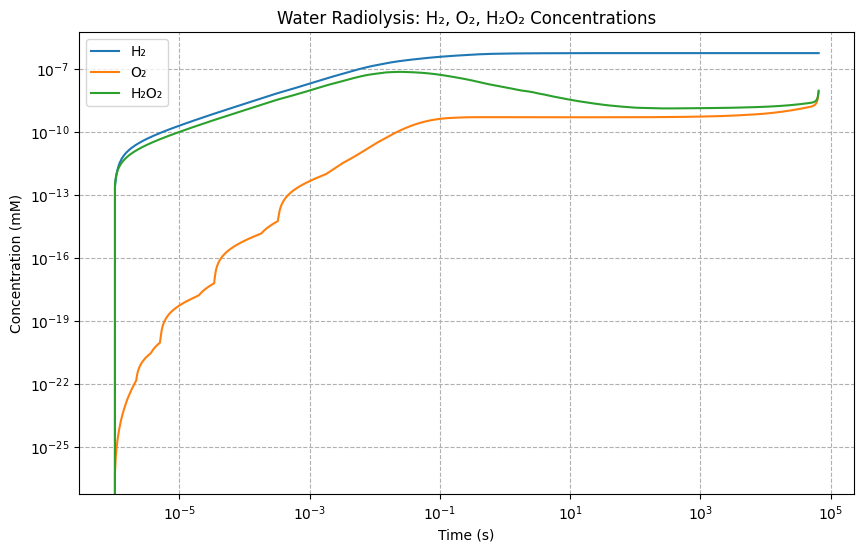

Final Concentrations at t = 10000000.0 s:
H₂: 5.551e-07 mM
O₂: 8.205e-09 mM
H₂O₂: 9.036e-09 mM


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
kB = 1.38e-23  # Boltzmann constant (J/K)
T = 298        # Temperature (K)
R = 8.314      # Gas constant (J/mol·K)
pCO2 = 4.12e-4 # Atmospheric CO2 partial pressure (atm, ~410 ppm in 2025)
H_CO2 = 3.3e-2 # Henry's constant for CO2 (mol/L·atm)

# Equilibrium constants (Buxton et al., approximate values at 25°C)
K_H2O = 1.8e-14  # Water dissociation (mol²/L²)
K_CO2_H2CO3 = 1.7e-3  # CO2 + H2O ⇌ H2CO3
K_H2CO3 = 4.3e-7  # H2CO3 ⇌ H⁺ + HCO₃⁻
K_HCO3 = 4.7e-11 # HCO₃⁻ ⇌ H⁺ + CO₃²⁻

# Reaction rate constants (M⁻¹ s⁻¹) from Buxton et al. (1988)
k1 = 2.6e10   # H• + OH• → H2O
k2 = 1.3e10   # e⁻(aq) + H⁺ → H•
k3 = 2.0e10   # e⁻(aq) + OH• → OH⁻
k4 = 2.3e7    # e⁻(aq) + H2O2 → OH• + OH⁻
k5 = 1.1e10   # OH• + OH• → H2O2
k6 = 5.5e9    # H• + H• → H2
k7 = 1.9e10   # e⁻(aq) + O2 → O₂⁻•
k8 = 1.9e10   # OH• + H2 → H• + H2O
k9 = 6.0e9    # OH• + H2O2 → HO₂• + H2O
k10 = 2.7e7   # HO₂• + HO₂• → H2O2 + O2
k11 = 1.0e6   # HCO₃⁻ + OH• → CO₃⁻• + H2O
k12 = 8.5e6   # CO₃⁻• + H2O2 → HCO₃⁻ + HO₂•
k13 = 3.0e7   # H• + O2 → HO₂•
k14 = 1.2e10  # e⁻(aq) + H2O → H• + OH⁻
k15 = 2.5e10  # e⁻(aq) + HO₂• → HO₂⁻
k16 = 1.0e10  # H• + H2O2 → OH• + H2O
k17 = 7.8e9   # OH• + HO₂• → H2O + O2
k18 = 1.0e10  # O₂⁻• + OH• → OH⁻ + O2
k19 = 1.8e10  # e⁻(aq) + O₂⁻• → HO₂⁻ + OH⁻
k20 = 3.5e9   # H• + HO₂• → H2O2
k21 = 8.3e9   # HO₂• + O₂⁻• → H2O2 + O2 + OH⁻
k22 = 4.2e8   # CO₃⁻• + O₂⁻• → CO₃²⁻ + O2
k23 = 3.9e8   # CO₃⁻• + HO₂• → HCO₃⁻ + O2

# Initial conditions (mM, user can modify)
initial_conditions = {
    'H': 1e-6,         # H• radical
    'OH': 1e-6,        # OH• radical
    'e_aq': 1e-6,      # Hydrated electron
    'H2': 0.0,         # Dissolved H2 (modify here)
    'O2': 0.0,         # Dissolved O2 (modify here)
    'H2O2': 0.0,       # Hydrogen peroxide
    'HO2': 0.0,        # Hydroperoxyl radical
    'O2_minus': 0.0,   # Superoxide radical
    'H_plus': 1e-4,    # H⁺ (pH ~ 4 initially)
    'OH_minus': 0.0,   # OH⁻
    'HO2_minus': 0.0,  # Peroxide ion
    'CO2_aq': pCO2 * H_CO2 * 1e3,  # Dissolved CO2 (mM)
    'H2CO3': 0.0,      # Carbonic acid
    'HCO3_minus': 0.0, # Bicarbonate
    'CO3_2minus': 0.0, # Carbonate
    'CO3_minus': 0.0   # Carbonate radical
}

# Convert initial conditions to array for solver (in mM)
y0 = np.array(list(initial_conditions.values()))

# Time span (seconds)
t_span = (1e-6, 1e7)
t_eval = np.logspace(-6, 7, 1000)

# Differential equations
def water_radiolysis(t, y):
    H, OH, e_aq, H2, O2, H2O2, HO2, O2_minus, H_plus, OH_minus, HO2_minus, CO2_aq, H2CO3, HCO3_minus, CO3_2minus, CO3_minus = y

    # Equilibrium adjustments (quasi-steady-state for carbonate system and water)
    H2CO3_eq = K_CO2_H2CO3 * CO2_aq
    HCO3_minus_eq = K_H2CO3 * H2CO3 / H_plus
    CO3_2minus_eq = K_HCO3 * HCO3_minus / H_plus
    OH_minus_eq = K_H2O / H_plus

    # Reaction rates (in mM/s, k * 1e-3 for concentration units)
    r1 = k1 * H * OH * 1e-3
    r2 = k2 * e_aq * H_plus * 1e-3
    r3 = k3 * e_aq * OH * 1e-3
    r4 = k4 * e_aq * H2O2 * 1e-3
    r5 = k5 * OH * OH * 1e-3
    r6 = k6 * H * H * 1e-3
    r7 = k7 * e_aq * O2 * 1e-3
    r8 = k8 * OH * H2 * 1e-3
    r9 = k9 * OH * H2O2 * 1e-3
    r10 = k10 * HO2 * HO2 * 1e-3
    r11 = k11 * HCO3_minus_eq * OH * 1e-3
    r12 = k12 * CO3_minus * H2O2 * 1e-3
    r13 = k13 * H * O2 * 1e-3
    r14 = k14 * e_aq * 1e-3  # Assuming constant [H2O] in rate
    r15 = k15 * e_aq * HO2 * 1e-3
    r16 = k16 * H * H2O2 * 1e-3
    r17 = k17 * OH * HO2 * 1e-3
    r18 = k18 * O2_minus * OH * 1e-3
    r19 = k19 * e_aq * O2_minus * 1e-3
    r20 = k20 * H * HO2 * 1e-3
    r21 = k21 * HO2 * O2_minus * 1e-3
    r22 = k22 * CO3_minus * O2_minus * 1e-3
    r23 = k23 * CO3_minus * HO2 * 1e-3

    # ODEs (dC/dt in mM/s)
    dH_dt = r2 + r8 - r1 - 2*r6 - r13 + r14 - r16 - r20
    dOH_dt = -r1 - r3 + r4 - 2*r5 - r8 - r9 - r11 - r17 - r18
    de_aq_dt = -r2 - r3 - r4 - r7 - r14 - r15 - r19
    dH2_dt = r6 - r8
    dO2_dt = r10 - r7 - r13 + r17 + r18 + r21 + r22 + r23
    dH2O2_dt = r5 - r4 - r9 + r10 - r12 - r16 + r20 + r21
    dHO2_dt = r9 + r13 - 2*r10 - r15 - r17 - r20 - r21 - r23 + r12
    dO2_minus_dt = r7 - r18 - r19 - r21 - r22
    dH_plus_dt = r2 - r3 - r4 - r14  # Simplified pH dynamics
    dOH_minus_dt = r3 + r4 + r14 + r15 + r18 + r19 + r21
    dHO2_minus_dt = r15 + r19
    dCO2_aq_dt = 0  # Assume constant CO2 from atmosphere
    dH2CO3_dt = 0   # Quasi-steady-state
    dHCO3_minus_dt = r12 - r11 + r23
    dCO3_2minus_dt = r22  # Quasi-steady-state contribution
    dCO3_minus_dt = r11 - r12 - r22 - r23

    return [dH_dt, dOH_dt, de_aq_dt, dH2_dt, dO2_dt, dH2O2_dt, dHO2_dt, dO2_minus_dt, dH_plus_dt,
            dOH_minus_dt, dHO2_minus_dt, dCO2_aq_dt, dH2CO3_dt, dHCO3_minus_dt, dCO3_2minus_dt, dCO3_minus_dt]

# Solve the system
solution = solve_ivp(water_radiolysis, t_span, y0, method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8)

# Extract results
species = list(initial_conditions.keys())
results = {species[i]: solution.y[i] for i in range(len(species))}

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(solution.t, results['H2'], label='H₂')
plt.loglog(solution.t, results['O2'], label='O₂')
plt.loglog(solution.t, results['H2O2'], label='H₂O₂')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mM)')
plt.title('Water Radiolysis: H₂, O₂, H₂O₂ Concentrations')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Report final concentrations
print(f"Final Concentrations at t = {t_span[1]} s:")
print(f"H₂: {results['H2'][-1]:.3e} mM")
print(f"O₂: {results['O2'][-1]:.3e} mM")
print(f"H₂O₂: {results['H2O2'][-1]:.3e} mM")